In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random

from collections import deque

from tqdm import tqdm

In [2]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.fc(x)


class ReplayBuffer:
    def __init__(self, capacity, state_dim):
        self.buffer = deque(maxlen=capacity)
        self.state_dim = state_dim

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s_, d = zip(*batch)
        return (
            torch.tensor(np.array([one_hot(x, self.state_dim) for x in s]), dtype=torch.float32),
            torch.tensor(a),
            torch.tensor(r, dtype=torch.float32),
            torch.tensor(np.array([one_hot(x, self.state_dim) for x in s_]), dtype=torch.float32),
            torch.tensor(d, dtype=torch.float32)
        )

    def __len__(self):
        return len(self.buffer)


def one_hot(state, state_dim):
    vec = np.zeros(state_dim, dtype=np.float32)
    vec[state] = 1.0
    return vec


def train_dqn(
        env, 
        policy_net, 
        target_net, 
        optimizer, 
        loss_fn, 
        device, 
        buffer, 
        episodes, 
        batch_size, 
        epsilon, 
        epsilon_decay, 
        epsilon_min, 
        gamma, 
        target_update_freq, 
        use_replay_buffer=True, 
        use_target_network=True
    ):
    returns_per_episode = []

    for ep in tqdm(range(episodes)):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            state_tensor = torch.tensor(one_hot(state, state_dim=env.observation_space.n), device=device)
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_vals = policy_net(state_tensor)
                    action = torch.argmax(q_vals).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            if use_replay_buffer:
                buffer.add((state, action, reward, next_state, done))
            else:
                # If not using replay buffer, learn immediately from the current transition
                s = torch.tensor(one_hot(state, state_dim=env.observation_space.n), device=device)
                a = torch.tensor([action], device=device)
                r = torch.tensor([reward], device=device)
                s_ = torch.tensor(one_hot(next_state, state_dim=env.observation_space.n), device=device)
                d = torch.tensor([done], device=device)

                q_values = policy_net(s).gather(0, a).squeeze()
                with torch.no_grad():
                    if use_target_network:
                        q_next = target_net(s_).max().item()
                    else:
                        q_next = policy_net(s_).max().item()
                    
                    q_target = r + gamma * q_next * (~d)

                loss = loss_fn(q_values, q_target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            state = next_state
            total_reward += reward

            # Learn from replay buffer if enabled
            if use_replay_buffer and len(buffer) >= batch_size:
                s, a, r, s_, d = [x.to(device) for x in buffer.sample(batch_size)]

                q_values = policy_net(s).gather(1, a.unsqueeze(1)).squeeze()
                with torch.no_grad():
                    if use_target_network:
                        q_next = target_net(s_).max(1)[0]
                    else:
                        q_next = policy_net(s_).max(1)[0]
                    q_target = r + gamma * q_next * (1 - d)

                loss = loss_fn(q_values, q_target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Update target network if enabled
        if use_target_network and (ep + 1) % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        returns_per_episode.append(total_reward)

    env.close()
    return returns_per_episode

In [3]:
# Environment
SIZE = 8
IS_SLIPPERY = False
env = gym.make('FrozenLake-v1', desc=None, map_name=f"{SIZE}x{SIZE}", is_slippery=IS_SLIPPERY)


# Hyperparameters
episodes = 5_000
gamma = 0.99

epsilon = 0.5
epsilon_decay = 0.999
epsilon_min = 0.01

lr = 0.001
batch_size = 256
target_update_freq = 50
memory_capacity = 100_000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/davide/Developer/rl-course/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 5000/5000 [00:30<00:00, 165.09it/s]


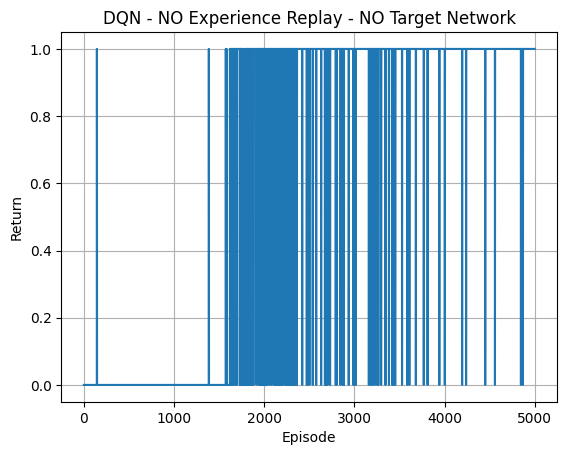

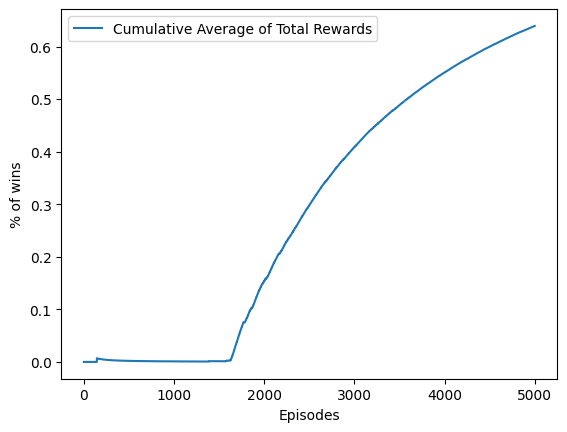

In [4]:
# Init
policy_net = DQN(state_dim=env.observation_space.n, action_dim=env.action_space.n).to(device)
target_net = DQN(state_dim=env.observation_space.n, action_dim=env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=lr)
loss_fn = nn.MSELoss()
buffer = ReplayBuffer(memory_capacity, state_dim=env.observation_space.n)

returns_per_episode = train_dqn(
    env, 
    policy_net, 
    target_net, 
    optimizer, 
    loss_fn,
    device,
    buffer, 
    episodes, 
    batch_size, 
    epsilon, 
    epsilon_decay, 
    epsilon_min, 
    gamma, 
    target_update_freq,
    use_replay_buffer=False,
    use_target_network=False
)

plt.plot(returns_per_episode)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("DQN - NO Experience Replay - NO Target Network")
plt.grid(True)
plt.show()

cumulative_avg = np.cumsum(returns_per_episode) / (np.arange(len(returns_per_episode)) + 1)
plt.plot(cumulative_avg, label='Cumulative Average of Total Rewards')
plt.xlabel('Episodes')
plt.ylabel('% of wins')
plt.legend()
plt.show()

100%|██████████| 5000/5000 [02:22<00:00, 35.18it/s]


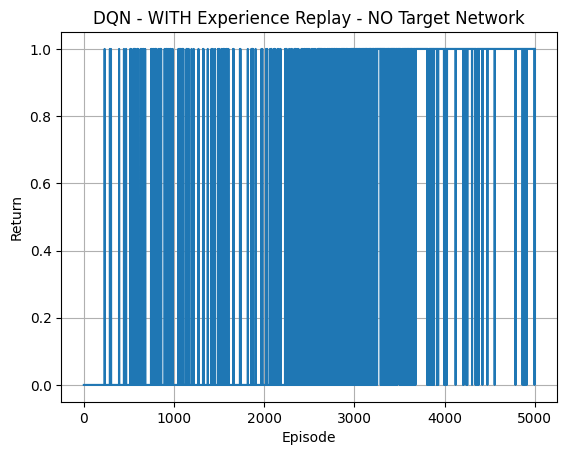

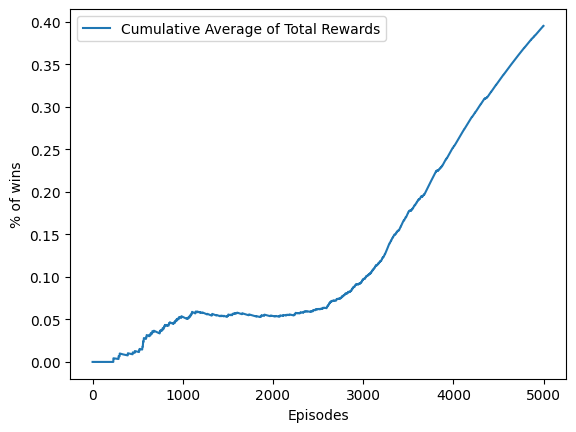

In [5]:
# Init
policy_net = DQN(state_dim=env.observation_space.n, action_dim=env.action_space.n).to(device)
target_net = DQN(state_dim=env.observation_space.n, action_dim=env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=lr)
loss_fn = nn.MSELoss()
buffer = ReplayBuffer(memory_capacity, state_dim=env.observation_space.n)

returns_per_episode = train_dqn(
    env, 
    policy_net, 
    target_net, 
    optimizer, 
    loss_fn,
    device,
    buffer, 
    episodes, 
    batch_size, 
    epsilon, 
    epsilon_decay, 
    epsilon_min, 
    gamma, 
    target_update_freq,
    use_replay_buffer=True,
    use_target_network=False
)

plt.plot(returns_per_episode)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("DQN - WITH Experience Replay - NO Target Network")
plt.grid(True)
plt.show()

cumulative_avg = np.cumsum(returns_per_episode) / (np.arange(len(returns_per_episode)) + 1)
plt.plot(cumulative_avg, label='Cumulative Average of Total Rewards')
plt.xlabel('Episodes')
plt.ylabel('% of wins')
plt.legend()
plt.show()

100%|██████████| 5000/5000 [01:15<00:00, 66.26it/s] 


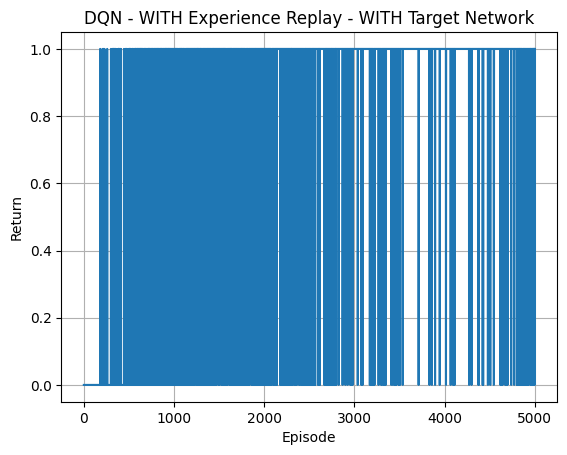

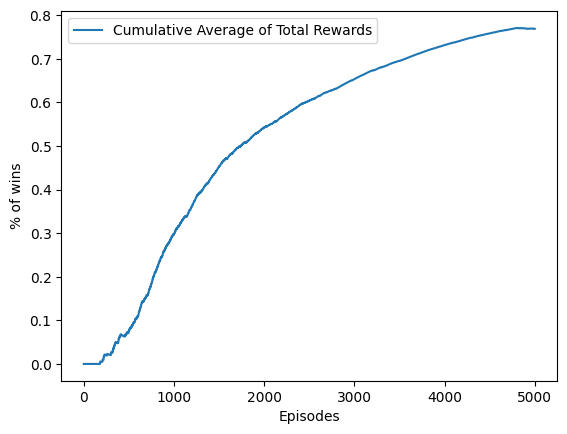

In [6]:
# Init
policy_net = DQN(state_dim=env.observation_space.n, action_dim=env.action_space.n).to(device)
target_net = DQN(state_dim=env.observation_space.n, action_dim=env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=lr)
loss_fn = nn.MSELoss()
buffer = ReplayBuffer(memory_capacity, state_dim=env.observation_space.n)


returns_per_episode = train_dqn(
    env, 
    policy_net, 
    target_net, 
    optimizer, 
    loss_fn,
    device,
    buffer, 
    episodes, 
    batch_size, 
    epsilon, 
    epsilon_decay, 
    epsilon_min, 
    gamma, 
    target_update_freq,
    use_replay_buffer=True,
    use_target_network=True
)

plt.plot(returns_per_episode)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("DQN - WITH Experience Replay - WITH Target Network")
plt.grid(True)
plt.show()

cumulative_avg = np.cumsum(returns_per_episode) / (np.arange(len(returns_per_episode)) + 1)
plt.plot(cumulative_avg, label='Cumulative Average of Total Rewards')
plt.xlabel('Episodes')
plt.ylabel('% of wins')
plt.legend()
plt.show()